# Plot histograms by basin
### LLC4320

In [21]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [22]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.7f25117d21aa41d3a588fa9cd5ff8138/status,


In [20]:
client.close()
cluster.close()

In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import gcsfs

In [24]:
#Load in tendencies by basin

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


#function to open each ds
def open_histograms(basin_file):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/basins/basin-histograms/' + 
                                              basin_file + '.zarr'))
    return ds

#function to rename vars 
def rename_data_vars(ds, prefix):
        
        new_ds = ds.rename_vars({f'OMEGA_{prefix}_cabbeling':'cabbeling',
                                 f'OMEGA_{prefix}_rho_lap': 'rho',
                                 f'OMEGA_{prefix}_sss':'sss',
                                 f'OMEGA_{prefix}_sst':'sst'})
        return new_ds

In [25]:
hist_names = ['natl_hist','npac_hist','arc_hist','south_hist','ind_hist']
hist = [] 

#load in basin mixing histograms
for name in hist_names:
    hist.append(open_histograms(name))
    for ds in hist:
        globals()[name] = ds

In [26]:
prefixes = ['NATL', 'NPAC', 'ARC', 'South', 'IND']

for (ds, prefix, name) in zip(hist, prefixes, hist_names):
    globals()[name] = rename_data_vars(ds, prefix)

In [27]:
natl_hist

<xarray.Dataset>
Dimensions:    (time: 377, rho0_bin: 199)
Coordinates:
  * rho0_bin   (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03 1.035e+03
  * time       (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-23
Data variables:
    cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    rho        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

In [34]:
def ann_mean(mix, basin_title, lower_bound=None, upper_bound=None):
    plt.rcParams['axes.grid']=True
    plt.rcParams['figure.autolayout']= False
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    line_colors=['blue', 'k', 
                 'orange', 'green']
    for (i,j) in zip(list(mix.data_vars), line_colors):
        (mix[i].mean('time')/1e6).plot(label=f'{i}', color=j, ax=ax0)
    
    #plotting mixing residual
    ((mix.rho + mix.cabbeling -
      mix.sss - mix.sst).mean('time')/1e6).plot(label='residual', color='grey', 
                                                                linestyle='dashed', ax=ax0)
    for (i,j) in zip(list(mix.data_vars), line_colors):
        (mix[i].mean('time')/1e6).plot(label=f'{i}', color=j, ax=ax1)
    
    ax0.legend()
    ax0.set_xlim(1016,1030)
    ax0.set_ylim(lower_bound, upper_bound)
    ax0.set_ylabel(r'Transformation (Sv)', fontsize=16)
    #ax0.grid()
    ax0.set_title('Mixing terms')
    ax0.set_xlabel('')
    
    ax1.legend()
    ax1.set_xlim(1016,1030)
    ax1.set_ylabel('')
    #ax1.grid()
    ax1.set_title('same fig')
    ax1.set_xlabel('')
    
    fig.supxlabel('Rho bins', fontsize=16)
    plt.suptitle('Annual Mean Transformation', fontsize=20)
    #plt.savefig(f'{basin_title}_ann_mean_hist_fig.pdf');

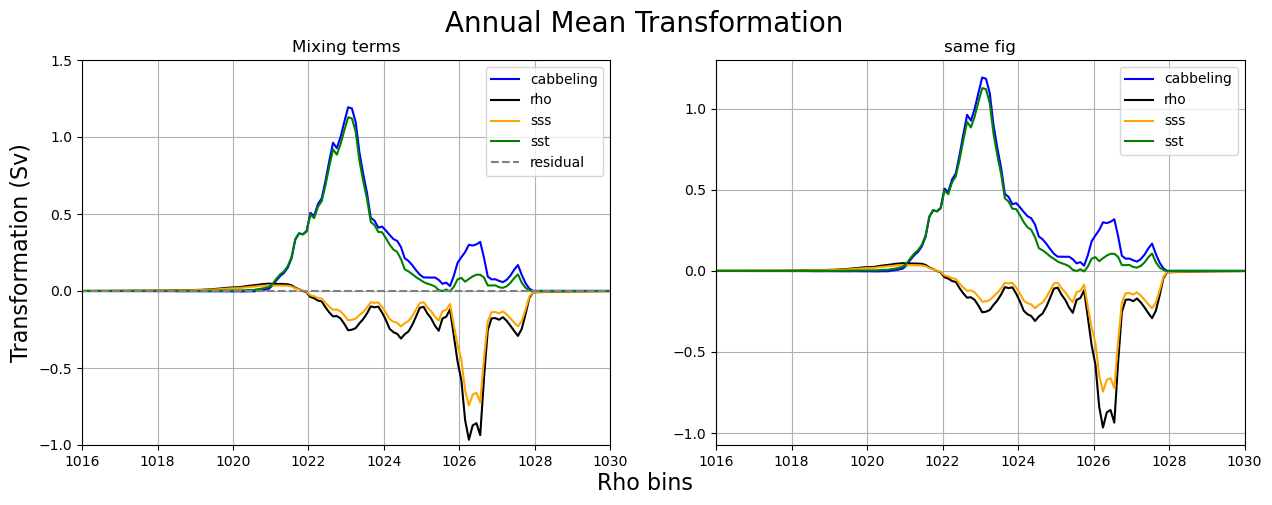

In [35]:
ann_mean(natl_hist, 'NATL', -1, 1.5)

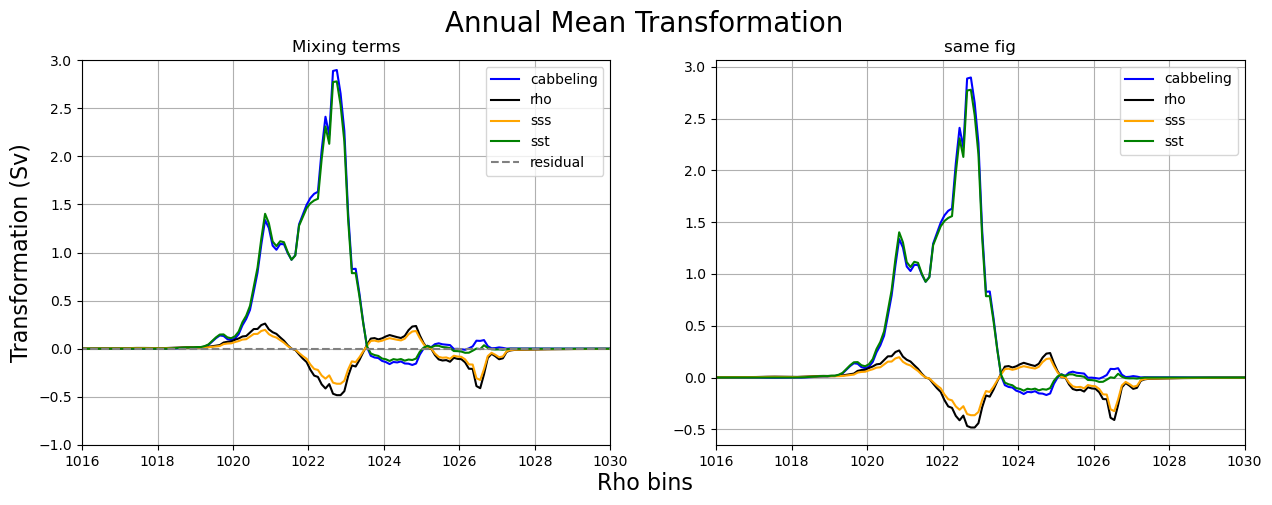

In [36]:
ann_mean(npac_hist, 'NPAC', -1, 3)

In [ ]:
ann_mean(arc_hist, 'ARC', -0.05, 0.15)

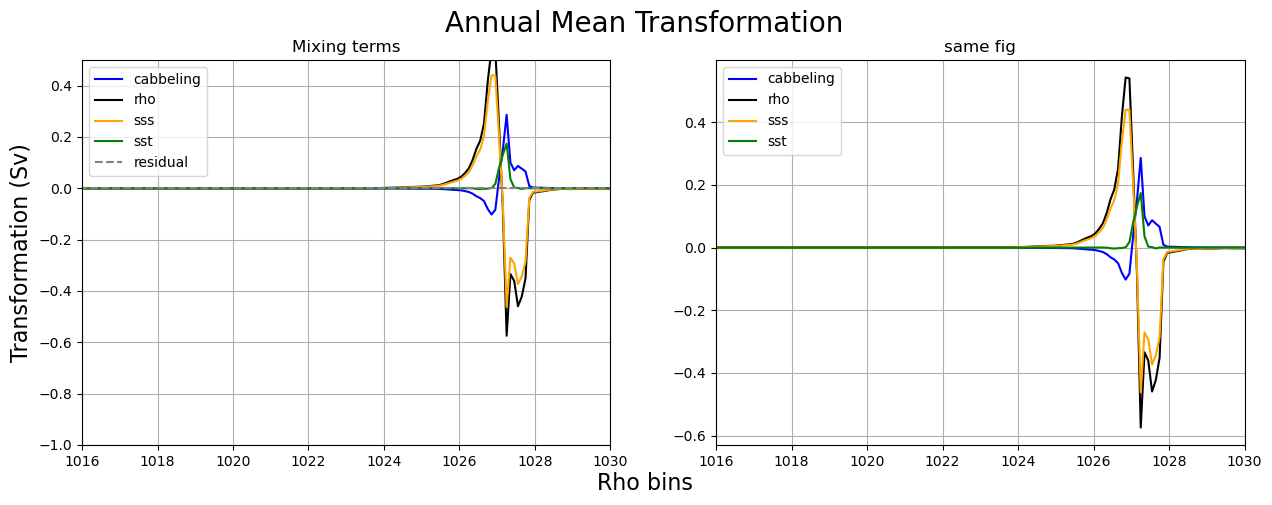

In [38]:
ann_mean(south_hist, 'South', -1, 0.5)

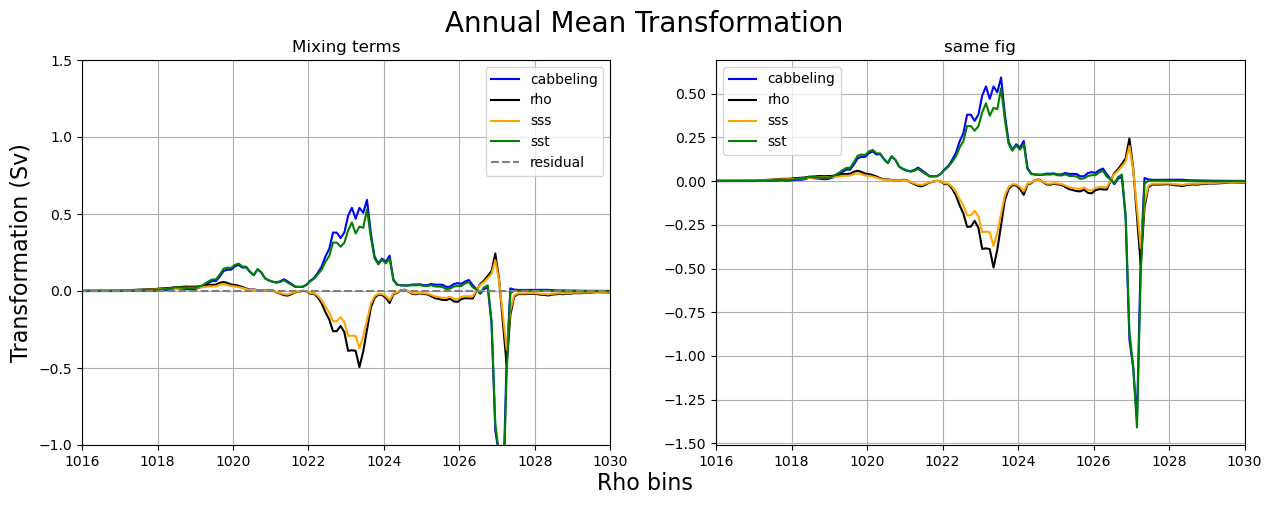

In [33]:
ann_mean(ind_hist, 'IND', -)